# Create the figure from ROMS output using 1-daily output

imports

In [3]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d
import gsw as gsw

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)
print("gsw version =", gsw.__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/JRA55"
os.chdir(wrkdir)

ProgressBar().register()


python version = 3.10.
numpy version = 1.26.0
xarray version = 2023.9.0
netCDF4 version = 1.6.4
dask version = 2023.3.0
pandas version = 2.1.1
scipy version = 1.11.3
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.22.0
cmocean version = v3.0.3
gsw version = 3.6.17


In [4]:
os.getcwd()

'/expanse/lustre/projects/ciw112/pbuchanan/JRA55'

In [5]:
os.listdir()

['JRA55_pic_1m_ptrc_T_2018-2022.nc',
 'JRA55_co2_1m_diad_T_Y2023.nc',
 'JRA55_13co2_1m_ptrc_T_1958-2022.nc',
 'JRA55_Ind_1y_grid_T_1958-2022.nc',
 'JRA55_ndep_1m_diad_T_2018-2022.nc',
 'JRA55_hydroOFF_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1y_diad_T_1958-2022.nc',
 'JRA55_pic_1m_diad_T_Y2023.nc',
 'JRA55_ndep_1m_diad_T_1998-2007.nc',
 'ORCA2.0.full_grid.nc',
 'JRA55_pic_1m_ptrc_T_1998-2007.nc',
 'JRA55_hydroOFF_1m_icemod_1958-2022.nc',
 'JRA55_pic_1m_icemod_1958-2022.nc',
 'JRA55_ndep_1y_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1y_bioscaler_1850-2022.nc',
 'JRA55_ndep_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1m_ptrc_T_1968-1977.nc',
 'JRA55_hydroOFF_1d_bioscaler_1958-2022.nc',
 'JRA55_pic_1m_ptrc_T_1978-1987.nc',
 'JRA55_SWInd_1y_grid_T_1958-2022.nc',
 'JRA55_pic_1m_grid_V_Y2023.nc',
 'JRA55_ndep_1m_ptrc_T_1958-1967.nc',
 'JRA55_hydroOFF_1m_diad_T_1958-1967.nc',
 'JRA55_pic_1m_diad_T_1958-1967.nc',
 'JRA55_SEInd_1y_ptrc_T_1958-2022.nc',
 'JRA55_ndep_1m_

Load model output

In [25]:
data = xr.open_dataset('JRA55_pic_1m_grid_T_1958-2022.nc')
temp = data['thetao']
salt = data['so']
mld = data['mldr10_1']

data = xr.open_dataset('JRA55_pic_1m_grid_U_1958-2022.nc')
uvel = data['uo']
data = xr.open_dataset('JRA55_pic_1m_grid_V_1958-2022.nc')
vvel = data['vo']
data = xr.open_dataset('JRA55_pic_1m_grid_W_1958-2022.nc')
wvel = data['wo']

fnames = ["JRA55_pic_1m_ptrc_T_1958-1967.nc",
          "JRA55_pic_1m_ptrc_T_1968-1977.nc",
          "JRA55_pic_1m_ptrc_T_1978-1987.nc",
          "JRA55_pic_1m_ptrc_T_1988-1997.nc",
          "JRA55_pic_1m_ptrc_T_1998-2007.nc",
          "JRA55_pic_1m_ptrc_T_2008-2017.nc",
          "JRA55_pic_1m_ptrc_T_2018-2022.nc"]
dat1 = xr.open_dataset(fnames[0])['Age']
dat2 = xr.open_dataset(fnames[1])['Age']
dat3 = xr.open_dataset(fnames[2])['Age']
dat4 = xr.open_dataset(fnames[3])['Age']
dat5 = xr.open_dataset(fnames[4])['Age']
dat6 = xr.open_dataset(fnames[5])['Age']
dat7 = xr.open_dataset(fnames[6])['Age']
age = xr.concat([dat1,dat2,dat3,dat4,dat5,dat6,dat7], dim="record")


#### change the dimension names and change the values of time coordinates

In [26]:
month = np.arange(1,13,1)
year = np.arange(1958.5,2022.51,1)

mld = mld.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month'})
temp = temp.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
salt = salt.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
age = age.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'deptht':'depth'})
uvel = uvel.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'depthu':'depth'})
vvel = vvel.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'depthv':'depth'})
wvel = wvel.assign_coords(record=year, time_counter=month).rename({'nav_lon':'lon', 'nav_lat':'lat', 'record':'year', 'time_counter':'month', 'depthw':'depth'})

temp

<xarray.DataArray 'thetao' (year: 65, month: 12, depth: 31, y: 149, x: 182)>
[655713240 values with dtype=float32]
Coordinates:
  * depth          (depth) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    lat            (y, x) float32 ...
    lon            (y, x) float32 ...
    time_centered  (month) object ...
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year           (year) float64 1.958e+03 1.96e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

Get Coordinates

In [27]:
fname = 'ORCA2.0.full_grid.nc' 
data = xr.open_dataset(fname)

lons = data['lon']
lats = data['lat']
deps = data.coords['depth']
deps_bnds = data['bounds_depth']
vol = data['volume']

Chunk the datasets

In [65]:
chunky = {'year':1, 'month':1, 'depth':31, 'y':149, 'x':182}

temp = temp.chunk(chunks=chunky)
salt = salt.chunk(chunks=chunky)
age = age.chunk(chunks=chunky)
uvel = uvel.chunk(chunks=chunky)
vvel = vvel.chunk(chunks=chunky)
wvel = wvel.chunk(chunks=chunky)

mldchunky = {'year':5, 'month':12, 'y':149, 'x':182}
mld = mld.chunk(chunks=mldchunky)

mld

<xarray.DataArray 'mldr10_1' (year: 65, month: 12, y: 149, x: 182)>
dask.array<rechunk-merge, shape=(65, 12, 149, 182), dtype=float32, chunksize=(5, 12, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    time_centered  (month) object dask.array<chunksize=(12,), meta=np.ndarray>
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year           (year) float64 1.958e+03 1.96e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: y, x
Attributes:
    standard_name:       ocean_mixed_layer_thickness_defined_by_sigma_theta
    long_name:           Mixed Layer Depth (dsigma = 0.01 wrt 10m)
    units:               m
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

Check the size of the arrays in Gb and their chunks in Mb

In [66]:
print("Total size of array in Gb", age.nbytes * 1e-9)
print("Total size of chunk in Mb", age.isel(year=1, month=1).nbytes * 1e-6)

print("Total size of array in Gb", mld.nbytes * 1e-9)
print("Total size of chunk in Mb", mld.isel(year=slice(0,5)).nbytes * 1e-6)


Total size of array in Gb 2.6228529600000003
Total size of chunk in Mb 3.362632
Total size of array in Gb 0.08460816
Total size of chunk in Mb 6.508319999999999


In [59]:
temp

<xarray.DataArray 'thetao' (year: 65, month: 12, depth: 31, y: 149, x: 182)>
dask.array<xarray-<this-array>, shape=(65, 12, 31, 149, 182), dtype=float32, chunksize=(1, 1, 31, 149, 182), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
    lat            (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    time_centered  (month) object dask.array<chunksize=(1,), meta=np.ndarray>
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year           (year) float64 1.958e+03 1.96e+03 ... 2.022e+03 2.022e+03
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)
    cell_measures:       area: area

#### Calculate rho from temperature and salinity

In [67]:
# 1) calculate absolute salinity and conservative temperature
asal = gsw.SA_from_SP(salt, temp.coords['depth'], temp.coords['lon'], temp.coords['lat'])
ctem = gsw.CT_from_pt(asal, temp)

# 2) calculate potential density
rho = gsw.density.rho(asal, ctem, temp.coords['depth'])
rho0 = gsw.density.sigma0(asal, ctem)

# 3) mask rho0 where there are zeros
rho = rho.where(salt > 0.0, other=np.nan)
rho0 = rho0.where(rho0 > 0.0, other=np.nan)


[########################################] | 100% Completed | 100.92 ms
[########################################] | 100% Completed | 101.78 ms
[########################################] | 100% Completed | 200.92 ms
[########################################] | 100% Completed | 100.62 ms
[########################################] | 100% Completed | 100.98 ms
[########################################] | 100% Completed | 200.77 ms
[########################################] | 100% Completed | 100.78 ms
[########################################] | 100% Completed | 200.96 ms
[########################################] | 100% Completed | 200.89 ms
[########################################] | 100% Completed | 100.60 ms
[########################################] | 100% Completed | 100.93 ms
[########################################] | 100% Completed | 200.74 ms
[########################################] | 100% Completed | 100.74 ms
[########################################] | 100% Completed | 20

#### check the result

[########################################] | 100% Completed | 100.80 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 102.02 ms
[########################################] | 100% Completed | 201.06 ms
[########################################] | 100% Completed | 201.28 ms
[########################################] | 100% Completed | 100.77 ms
[########################################] | 100% Completed | 200.89 ms
[########################################] | 100% Completed | 200.95 ms
[########################################] | 100% Completed | 101.02 ms
[########################################] | 100% Completed | 201.07 ms
[########################################] | 100% Completed | 201.57 ms
[########################################] | 100% Completed | 201.38 ms
[########################################] | 100% Completed | 20

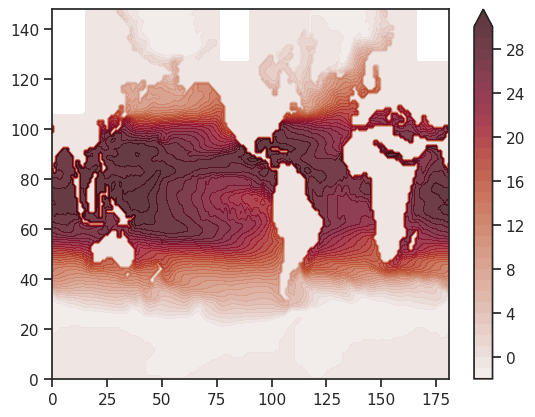

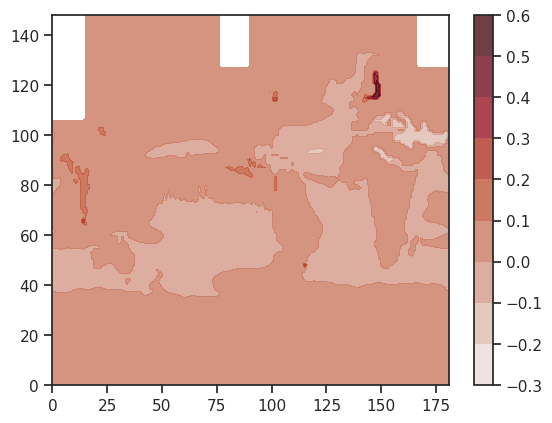

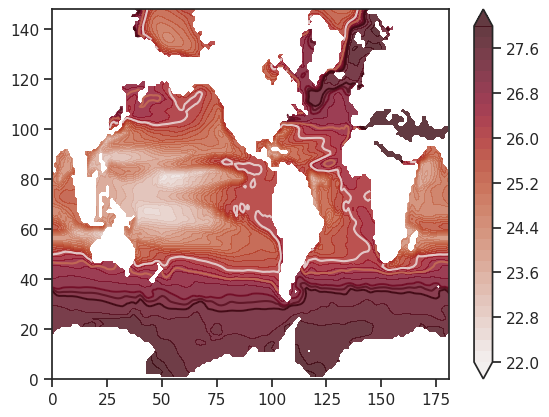

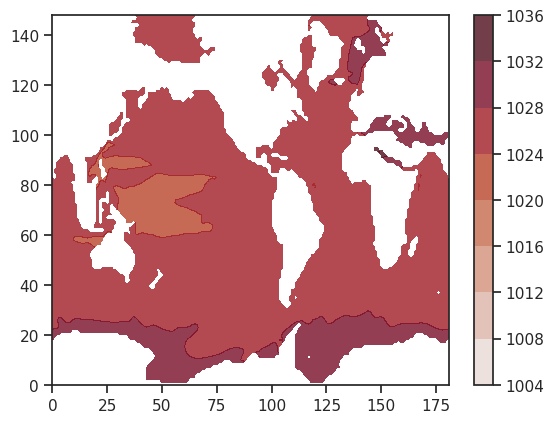

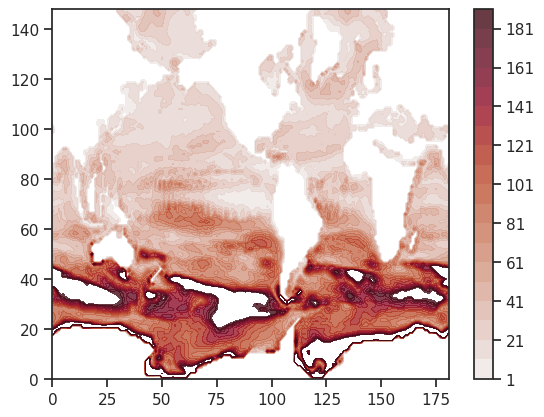

In [61]:

proj = ccrs.Robinson(central_longitude=40)
levs = np.arange(-2,31,1)
colmap = lighten(cmo.amp, alpha=0.8)

plt.figure()
ax1 = plt.subplot()
p1 = ax1.contourf(temp.isel(year=1, month=8, depth=1), cmap=colmap, levels=levs, extend='max')
plt.colorbar(p1)

plt.figure()
ax1 = plt.subplot()
p1 = ax1.contourf((ctem-temp).isel(year=1, month=8, depth=1), cmap=colmap)
plt.colorbar(p1)

levs = np.arange(22,28.1,0.2)
plt.figure()
ax1 = plt.subplot()
p1 = ax1.contourf(rho0.isel(year=1, month=8, depth=10), cmap=colmap, levels=levs, extend='both')
ax1.contour(rho0.isel(year=1, month=8, depth=10), cmap=colmap, levels=np.array([26.0, 26.5, 27.0, 27.1, 27.2]))
plt.colorbar(p1)

plt.figure()
ax1 = plt.subplot()
p1 = ax1.contourf(rho.isel(year=1, month=8, depth=10), cmap=colmap)
plt.colorbar(p1)

plt.figure()
ax1 = plt.subplot()
p1 = ax1.contourf(mld.isel(year=1, month=8), cmap=colmap, levels=np.arange(1,200,10))
plt.colorbar(p1)

### get the isopycnal bounds

In [68]:
#%% get the isopycnal bounds
samw_bnds = [1026.5, 1027.1]
aaiw_bnds = [1027.1, 1027.4]


### Find the depth levels where the mixed layer depth extends to

In [71]:
#%% Find the depth levels where mixed layer depths extend to

klevel = np.zeros(np.shape(mld))
mld_t = mld.values


[########################################] | 100% Completed | 6.43 ss
[########################################] | 100% Completed | 6.53 s
[########################################] | 100% Completed | 6.54 s


In [ ]:
for i in np.arange(len(mld_t[0,0,0,:])):
    print(i)
    for j in np.arange(len(mld_t[0,0,:,0])):
        if mld_t[0,0,j,i] == 0.0:
            continue
        else:
            for m in np.arange(len(mld_t[0,:,0,0])):
                for y in np.arange(len(mld_t[:,0,0,0])):
                    for k,z in enumerate(deps):
                        if mld_t[y,m,j,i] > deps_bnds.values[0][k] and mld_t[y,m,j,i] <= deps_bnds.values[1][k]:
                            klevel[y,m,j,i] = k 




0
1


In [46]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_fig_for_NOx_paper_nitriteoxidation.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/roms_fig_for_NOx_paper_nitriteoxidation_transparent.png", dpi=300, transparent=True)